# Fixed hyperbolic gaussian
> After addressing some issues with the tangent plane...

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from src.hyperdt.toy_data import wrapped_normal_mixture
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from src.hyperdt.conversions import convert


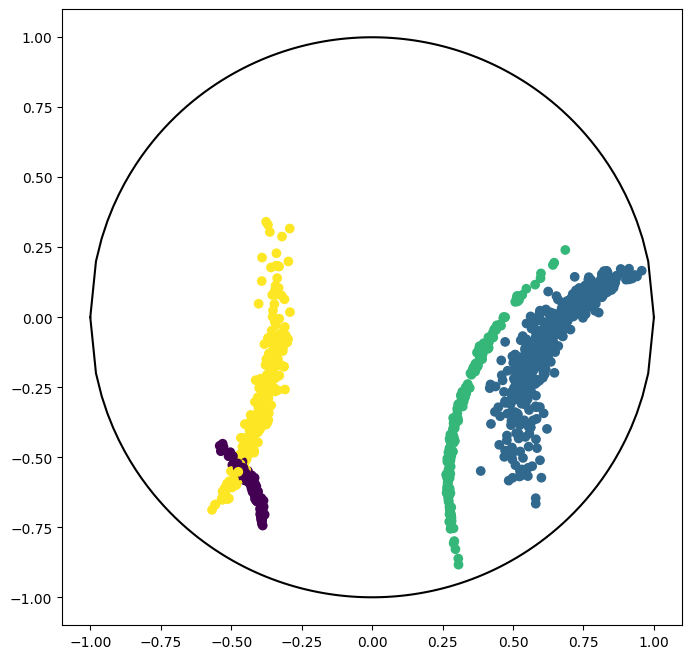

In [86]:
# Get data
X, y = wrapped_normal_mixture(
    num_points=1000, num_classes=4, noise_std=0.1, n_dim=2
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Plot
X_poincare = convert(X, "hyperboloid", "poincare")
plt.figure(figsize=(8, 8))
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x ** 2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")


  0%|          | 0/100 [00:00<?, ?it/s]

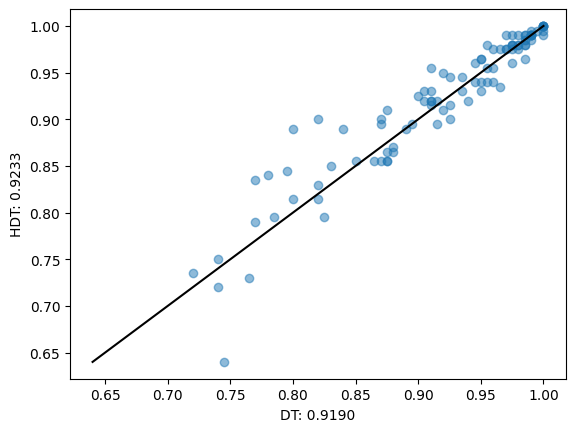

LDT: 0.9252


In [101]:
# Try a bunch of different versions:

# Hyperparameters
MAX_DEPTH = 8
N_CLASSES = 4
N_DIM = 2

# Some geomstats objects
manifold = Hyperbolic(dim=N_DIM, default_coords_type="extrinsic")
origin = np.array([1.0] + [0.0] * N_DIM)

# Main loop
dt_accs = []
hdt_accs = []
ldt_accs = []
for _ in tqdm(range(100)):
    X, y = wrapped_normal_mixture(
        num_points=1000,
        num_classes=N_CLASSES,
        noise_std=0.1,
        n_dim=N_DIM,
        seed=None,
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Hyperbolic decision tree
    hdt = HyperbolicDecisionTreeClassifier(
        max_depth=MAX_DEPTH, candidates="grid"
    )
    hdt.fit(X_train, y_train)

    # Euclidean decision tree + hyperboloid
    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt.fit(X_train, y_train)

    # Euclidean decision tree + log map
    X_train_log = manifold.metric.log(X_train, base_point=origin)
    X_test_log = manifold.metric.log(X_test, base_point=origin)
    dt_log = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt_log.fit(X_train_log, y_train)

    dt_accs.append(accuracy_score(y_test, dt.predict(X_test)))
    hdt_accs.append(accuracy_score(y_test, hdt.predict(X_test)))
    ldt_accs.append(accuracy_score(y_test, dt_log.predict(X_test_log)))


# Plotting code
plt.scatter(dt_accs, hdt_accs, alpha=0.5)
plt.xlabel(f"DT: {np.mean(dt_accs):.4f}")
plt.ylabel(f"HDT: {np.mean(hdt_accs):.4f}")
minval = np.min([np.min(dt_accs), np.min(hdt_accs)])
plt.plot([minval, 1], [minval, 1], c="black")
plt.show()
print(f"LDT: {np.mean(ldt_accs):.4f}")


In [55]:
from geomstats.geometry.hyperbolic import Hyperbolic

manifold = Hyperbolic(dim=2)


In [65]:
sample = np.random.normal(size=(100, 2))
np.concatenate([np.zeros((sample.shape[0], 1)), sample], axis=1)


In [94]:
manifold.metric.log(
    point=X,
    base_point=np.array([1.0, 0.0, 0.0]),
)


array([[-1.11022302e-15, -1.36500239e+00,  7.04167749e-01],
       [ 4.44089210e-15, -1.19329276e+00,  1.73997190e+00],
       [ 0.00000000e+00, -1.83791140e+00,  9.18211863e-01],
       ...,
       [ 0.00000000e+00, -2.68310195e-01,  3.25063948e-02],
       [ 3.99680289e-15, -1.19078435e+00,  2.00712873e+00],
       [ 0.00000000e+00,  4.78218936e-01,  8.70650420e-02]])